<a href="https://colab.research.google.com/github/nikitakaraevv/pointnet/blob/master/nbs/PointNetClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PointNet

This is an implementation of [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://arxiv.org/abs/1612.00593) using PyTorch.


## Getting started

Don't forget to turn on GPU if you want to start training directly. 


**Runtime** -> **Change runtime type**-> **Hardware accelerator**



In [1]:
import numpy as np
import math
import random
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

In [15]:
# !pip install path.py;
# from path import Path

In [2]:
random.seed = 42

Download the [dataset](http://3dvision.princeton.edu/projects/2014/3DShapeNets/) directly to the Google Colab Runtime. It comprises 10 categories, 3,991 models for training and 908 for testing.



**IMPORTANT**


The ModelNet10 dataset originally consists of 3D models represented as meshes. A mesh is defined by a collection of vertices (points in space) and faces (polygons that connect these vertices, usually triangles or quadrilaterals).

In the tutorial you’re following, the meshes are being converted to point cloud representations. This is because PointNet and similar models work directly on point clouds rather than meshes.

**Why Convert Meshes to Point Clouds?**
PointNet and Point Cloud-Based Models: These models are designed to take point clouds as input, not meshes. A point cloud is simply a set of points that represent the surface of an object without any explicit connectivity information like faces in a mesh.

Simplification: Point clouds are a simpler representation compared to meshes. They consist of just (x, y, z) coordinates (and possibly other features like color), making them easier to process for certain machine learning tasks.

Uniform Sampling: The PointSampler class in your tutorial is used to convert the mesh into a uniform point cloud, ensuring that the surface of the object is represented accurately by a set number of points, regardless of the complexity of the original mesh.

**Summary:**
Original Data (ModelNet10): Meshes (vertices and faces).
Converted Data: Point clouds (uniformly sampled points from the surface of the meshes).
Purpose: To use these point clouds as input to PointNet for tasks like classification, segmentation, etc.
This conversion makes it possible to leverage the power of PointNet and similar architectures for 3D object analysis.

In [ ]:
# !wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

# or simple copy paste this in your browser: http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

In [ ]:
# !unzip -q ModelNet10.zip; ## need the python zipping library to be installed first

# or simply use winzip to unzip it (or any other zip file reader)

In [5]:
from pathlib import Path
path = Path("F:\datasets\ModelNet10\Princeton_ModelNet_dataset")

In [6]:
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

This dataset consists of **.off** files that contain meshes represented by *vertices* and *triangular faces*. 

We will need a function to read this type of files:

In [7]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

In [22]:
with open(path/"bed/train/bed_0003.off", 'r') as f:
  verts, faces = read_off(f)

In [26]:
x,y,z = np.array(verts).T
i,j,k = np.array(faces).T

print(x[0],y[0],z[0]) ## vertics : the point forming a corner in the shape.
print(i[0],j[0],k[0]) ## face : sruface consisting of 3 (or 4 sometimes) points, and is represneted by the indicies of the points forming that face.

19.29135 39.3701 -8.66145
0 1 2


In [32]:
print('len(x)', len(x))
print('len(i)', len(i))

len(x) 2644
len(i) 2440


Don't be afraid of this huge function. It's  just to display animated rotation of meshes and point clouds.

In [33]:
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
                    layout=go.Layout(
                        updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                    transition=dict(duration=0),
                                                                    fromcurrent=True,
                                                                    mode='immediate'
                                                                    )]
                                                    )
                                            ]
                                    )
                                ]
                    ),
                    frames=frames
            )

    return fig

In [34]:
visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='skyblue', opacity=0.50, i=i,j=j,k=k)]).show()

This mesh definitely looks like a bed.

In [35]:
visualize_rotate([go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers')]).show()

Unfortunately, that's not the case for its vertices. It would be difficult for PointNet to classify point clouds like this one.

First things first, let's write a function to accurately visualize point clouds so we could see vertices better.




**pcshow Function:**
The pcshow function is a utility for visualizing 3D point clouds using Plotly. Here’s what it does:





**Function Details:**

Inputs: Takes xs, ys, and zs, which are arrays of x, y, and z coordinates for the points in the point cloud.





**Plotly Visualization:**

go.Scatter3d is a Plotly object that visualizes points in 3D space.
mode='markers' indicates that each point is represented as a marker.
fig.update_traces(...) updates the size and color of the markers for better visibility.




**Visualization:**

fig.show() renders the interactive 3D plot in the browser, allowing for rotation and zooming.
Purpose: To visualize a 3D point cloud interactively.

In [36]:
def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()
    

In [37]:
pcshow(x,y,z)

## Transforms

As we want it to look more like a real bed, let's write a function to sample points on the surface uniformly.

**The PointSampler class is a utility for sampling a fixed number of points from a 3D mesh. It converts a mesh (defined by vertices and faces) into a point cloud representation**



**Explanation:**

**Purpose:** Converts a 3D mesh into a point cloud by sampling points uniformly from the surface of the mesh.




**Sampling Logic:**

Computes the area of each triangular face in the mesh.
Uses the area as weights to sample faces, ensuring that larger faces have a higher probability of contributing points.
Within each sampled face, it generates a random point using barycentric coordinates.




**Output:**

A point cloud with a fixed number of points (output_size).

 ### Sample points

In [16]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points
    

In [55]:
pointcloud = PointSampler(3000)((verts, faces))

In [56]:
pcshow(*pointcloud.T)

This pointcloud looks much more like a bed!

### Normalize

### Unit sphere



**The function returns the normalized point cloud, where:**

**The center of the object is at the origin.**
All points are within a unit sphere (maximum distance from the origin is 1).

**Purpose in the Context of PointNet:**
Normalization is an important preprocessing step for point clouds to ensure that the model learns features independent of the object’s position and size in the coordinate space. This helps the model generalize better across different objects and scales.

In [57]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [58]:
norm_pointcloud = Normalize()(pointcloud)

In [59]:
pcshow(*norm_pointcloud.T)

Notice that axis limits have changed.

### Augmentations

Let's add *random rotation* of the whole pointcloud and random noise to its points.



## `RandRotation_z` Class
- **Purpose**: 
  - Randomly rotates a 3D point cloud around the z-axis to augment data and make the model invariant to rotation.

- **How It Works**:
  - Generates a random rotation angle `theta` in the range `[0, 2π]` (remember that `[0, 2π]` is a full rotation).
  - Constructs a 3x3 rotation matrix specific to the z-axis:
    - The matrix rotates points in the `xy`-plane while keeping the `z` coordinates unchanged.
    - The rotation matrix is:
      \[
      \begin{bmatrix}
      \cos(\theta) & -\sin(\theta) & 0 \\
      \sin(\theta) & \cos(\theta) & 0 \\
      0 & 0 & 1
      \end{bmatrix}
      \]
  - Applies this matrix to the entire point cloud using matrix multiplication.
  - Transposes the point cloud for proper matrix operations and returns it to its original shape.

- **Result**:
  - The function outputs the rotated point cloud, which appears the same from above but rotated in the `xy` plane.

## `RandomNoise` Class
- **Purpose**:
  - Adds random Gaussian noise to each point in the point cloud to simulate real-world imperfections and make the model robust to noisy inputs.

- **How It Works**:
  - Creates noise with a mean of `0` and a standard deviation of `0.02` for each coordinate in the point cloud.
  - Adds this noise to each point `(x, y, z)` in the cloud.
  - The addition of noise slightly perturbs each point in all directions.

- **Result**:
  - The function returns a noisy version of the input point cloud, where each point is slightly shifted from its original position.


In [60]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [61]:
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)

In [62]:
pcshow(*noisy_rot_pointcloud.T)

### ToTensor

In [63]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [64]:
ToTensor()(noisy_rot_pointcloud)

tensor([[-0.2824, -0.2400, -0.0282],
        [-0.5527, -0.5620,  0.3591],
        [-0.7275, -0.0946,  0.3514],
        ...,
        [ 0.8793,  0.0189, -0.1472],
        [ 0.6688, -0.1432, -0.1366],
        [-0.6028,  0.1693, -0.1982]], dtype=torch.float64)

In [65]:
def default_transforms():
    return transforms.Compose([
                                PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

## Dataset

Now we can create a [custom PyTorch Dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [66]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

Transforms for training. 1024 points per cloud as in the paper!

In [67]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [68]:
train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

In [69]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [70]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([1024, 3])
Class:  bathtub


In [71]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

## Model

### Let's break down the intuition behind PointNet and how it differs from 2D image analysis

1. **Understanding the Input: 3D Point Clouds vs. 2D Images**
   - **2D Images**: Represented as a grid of pixels. Each pixel has a fixed location and a value (e.g., RGB color).
   - **3D Point Clouds**: Represented as a collection of points in 3D space, each with an (x, y, z) coordinate. Unlike images, there is no fixed grid structure.

2. **Challenges in 3D Analysis**
   - **Permutation Invariance**: The order of points in a point cloud doesn’t matter (unlike pixels in an image). A model needs to recognize the same shape regardless of the point order.
   - **Rotational Invariance**: The model should recognize the same object even when rotated in space.
   - **No Fixed Structure**: Unlike images, 3D point clouds don’t have a consistent layout.

3. **PointNet Logic and Architecture**

   **A. Input Transformation with TNet**
   - **Purpose**: The TNet modules learn to align the input points and feature space into a canonical form. This is somewhat like learning how to "rotate" or "move" a 3D object so it always looks the same to the network, reducing variability in data.
     - **Analogy**: Imagine recognizing a rotated image of a cat by learning to rotate it back to an upright position before classification.

   **B. Feature Extraction**
   - **PointNet applies 1D Convolutions** over the input points to extract features. In 2D CNNs, convolutions slide over pixels in a 2D grid; here, convolutions operate over points in a 1D manner, treating each point as a feature vector.

   The input to PointNet is typically a set of all points representing a 3D object, like a chair or a car. This input is a collection of points, each with its own (x, y, z) coordinates, and possibly additional features like color or intensity.

   - **Input Structure:**
     - Shape: `(batch_size, num_points, num_features)`

   - **Example**: For a chair, the input could be 1,024 points, each with 3 features `(x, y, z)` coordinates.

   - **Detailed Example:**
     - Suppose you have a 3D model of a chair made up of 1,024 points.
     - The input tensor for a batch of 32 chairs would be:
       - Shape: `(32, 1024, 3)`
       - Each entry in the tensor represents a point in 3D space, e.g., `[0.5, -1.2, 0.3]`.

   - **Convolution in PointNet:**
     - 1D Convolution: Applies across the `num_features` dimension of each point.
     - **Purpose**: Transforms each point's features independently, similar to how a 2D convolution extracts features like edges or textures from image pixels.

       - **Intuition**: Each point independently extracts local features, like edges or textures in image analysis.

   **C. Global Feature Aggregation**
   - **Max Pooling**: After local features are extracted, PointNet uses max pooling over all points to get a global feature vector. This step is crucial because it allows the network to be invariant to the order of points.
     - **Analogy**: In an image, max pooling helps to retain the most prominent features from a region. Here, it captures the most critical feature across all points, no matter where they are.

   **D. Fully Connected Layers**
   - The global feature vector is passed through fully connected layers to perform the final classification.
     - **Analogy**: Like a regular classifier at the end of a 2D CNN that maps features to class scores.

4. **Key Intuitions for 3D Data:**
   - **No Grid, Just Points**: Think of points as "independent pixels" floating in space without a fixed order.
   - **Alignment and Canonical Form**: The network learns to "rotate" and "position" objects in a way that makes them easier to recognize.
   - **Global Representation**: Instead of considering spatial relations directly, the network pools information globally, focusing on the most prominent shape features.

**In summary**, while 2D CNNs extract features through structured filters over a grid, PointNet learns to process unordered point sets by transforming, extracting features from each point, and then aggregating these features to form a global understanding of the shape. This approach makes it powerful for directly analyzing raw 3D data without converting it into other forms like voxel grids or meshes.


In [72]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [73]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss() ## The negative log likelihood loss.
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

## Training loop

You can find a pretrained model [here](https://drive.google.com/open?id=1nDG0maaqoTkRkVsOLtUAR9X3kn__LMSL)

In [74]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [75]:
pointnet = PointNet()
pointnet.to(device);
pointnet

PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,

In [76]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [77]:
def train(model, train_loader, val_loader=None,  epochs=15, save=True):
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        if save:
            torch.save(pointnet.state_dict(), "save_"+str(epoch),".pth")

In [ ]:
train(pointnet, train_loader, valid_loader,  save=False)

[Epoch: 1, Batch:   10 /  125], loss: 2.016
[Epoch: 1, Batch:   20 /  125], loss: 1.649
[Epoch: 1, Batch:   30 /  125], loss: 1.486
[Epoch: 1, Batch:   40 /  125], loss: 1.381
[Epoch: 1, Batch:   50 /  125], loss: 1.443
[Epoch: 1, Batch:   60 /  125], loss: 1.125
[Epoch: 1, Batch:   70 /  125], loss: 0.957
[Epoch: 1, Batch:   80 /  125], loss: 0.869
[Epoch: 1, Batch:   90 /  125], loss: 1.005
[Epoch: 1, Batch:  100 /  125], loss: 1.003
[Epoch: 1, Batch:  110 /  125], loss: 0.938
[Epoch: 1, Batch:  120 /  125], loss: 0.944
Valid accuracy: 62 %
[Epoch: 2, Batch:   10 /  125], loss: 0.816
[Epoch: 2, Batch:   20 /  125], loss: 0.813
[Epoch: 2, Batch:   30 /  125], loss: 0.874
[Epoch: 2, Batch:   40 /  125], loss: 0.830
[Epoch: 2, Batch:   50 /  125], loss: 0.848
[Epoch: 2, Batch:   60 /  125], loss: 0.750
[Epoch: 2, Batch:   70 /  125], loss: 0.761
[Epoch: 2, Batch:   80 /  125], loss: 0.806
[Epoch: 2, Batch:   90 /  125], loss: 0.796
[Epoch: 2, Batch:  100 /  125], loss: 0.746
[Epoch: 2, 

## Test

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load('save.pth', map_location=torch.device('cpu')))
pointnet.eval();

In [58]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())
        


NameError: name 'valid_loader' is not defined

In [47]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[ 41,   9,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  97,   2,   0,   0,   0,   0,   1,   0,   0],
       [  0,   0, 100,   0,   0,   0,   0,   0,   0,   0],
       [  1,   2,   2,  34,   4,   0,  19,   4,  19,   1],
       [  0,   0,   0,   0,  41,   0,  44,   0,   1,   0],
       [  0,   0,   1,   0,  26,  71,   1,   1,   0,   0],
       [  0,   0,   1,   0,   6,   0,  79,   0,   0,   0],
       [  1,   1,   1,   0,   1,   0,   1,  95,   0,   0],
       [  0,   0,   0,   6,   0,   0,   1,   0,  93,   0],
       [  1,   1,  13,   0,   2,   0,   1,   1,   0,  81]], dtype=int64)

In [48]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


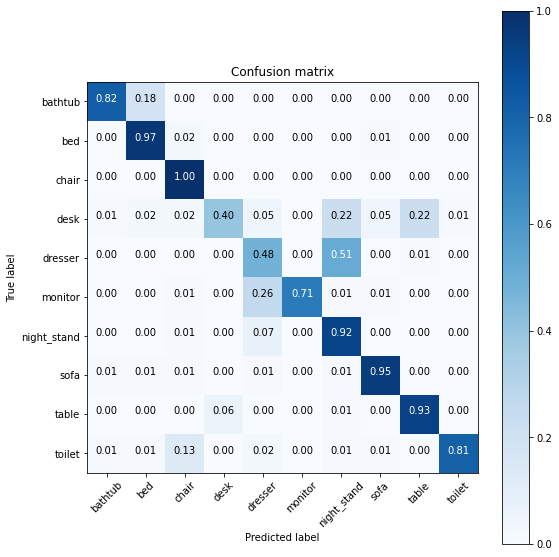

In [49]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Confusion matrix, without normalization


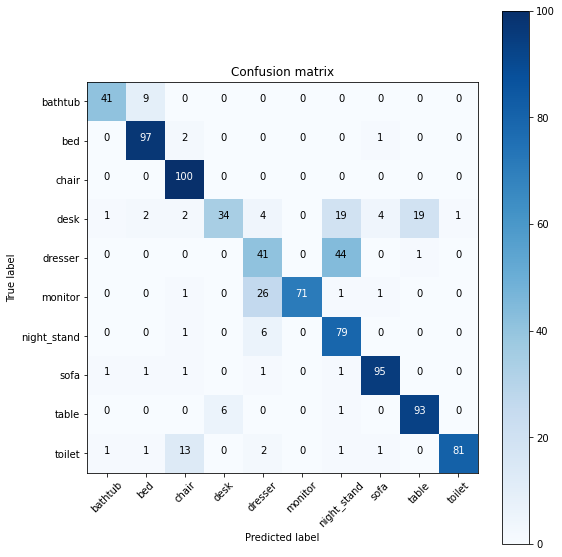

In [50]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)